In [25]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:


 

class NWave:

    def __init__(self, ts, filt, level):

        self.ts = ts

        self.filt = filt

        self.level = level

 

    def set_filt(self, filt):

        self.filt = filt

 

    def set_level(self, level):

        self.level = level

   

    

    

    def modwt(self, raw=False):

        wavelet = pywt.Wavelet(self.filt)

        h = wavelet.dec_hi

        g = wavelet.dec_lo

        h_t = np.array(h) / np.sqrt(2)

        g_t = np.array(g) / np.sqrt(2)

        wavecoeff = []

        v_j_1 = self.ts

       

        def _circular_convolve_d(h_t, v_j_1, j):

            """

            jth level decomposition

            h_t : \tilde{h} = h / sqrt(2)

            v_j_1 = v_{j-1}, the (j-1)th scale coefficients

            retrn w_j (or v_j)

            """

            N = len(v_j_1)

            L = len(h_t)

            w_j = np.zeros(N)

            l = np.arange(L)
            for t in range(N):

                index = np.mod(t - 2**(j-1)*l, N)

                v_p = np.array([v_j_1[i] for i in index])

                w_j[t] = (np.array(h_t)*v_p).sum()

            return w_j

       

        for j in range(self.level):

            w = _circular_convolve_d(h_t, v_j_1, j+1)

            v_j_1 = _circular_convolve_d(g_t, v_j_1, j+1)

            wavecoeff.append(w)

        wavecoeff.append(v_j_1)

        w = np.vstack(wavecoeff)

        if not raw:

            df = pd.DataFrame(w).T

            df.columns = ["W_"+str(i) for i in range(w.shape[0]-1)] + ["V"]

            return df

        return w

 

 

    def modwtmra(self, df=True):

        w = self.modwt(raw=True)

        wavelet = pywt.Wavelet(self.filt)

        h = wavelet.dec_hi

        g = wavelet.dec_lo

       

        def _up_arrow_op(li, j):

            if j == 0:

                return [1]

            N = len(li)

            li_n = np.zeros(2**(j-1)*(N-1) + 1)

            for i in range(N):

                li_n[2**(j-1)*i] = li[i]

            return li_n

       

        def _period_list(li, N):

            n = len(li)

            n_app = N - np.mod(n, N)

            li = list(li)

            li = li + [0]*n_app

            if len(li) < 2*N:

                return np.array(li)

            else:

                li = np.array(li)

                li = np.reshape(li, [-1, N])

                li = np.sum(li, axis=0)

                return li

       

        def _circular_convolve_mra(h_j_o, w_j):

            N = len(w_j)

            l = np.arange(N)

            D_j = np.zeros(N)

            for t in range(N):

                index = np.mod(t+l, N)

                w_j_p = np.array([w_j[i] for i in index])

                D_j[t] = (np.array(h_j_o)*w_j_p).sum()

            return D_j

       

        # D

        level, N = w.shape

        level -= 1

        D = []

        g_j_part = [1]

       

        for j in range(level):

            g_j_up = _up_arrow_op(g, j+1)

            g_j_part = np.convolve(g_j_part, g_j_up)

            h_j_up = _up_arrow_op(h, j+1)

            h_j = np.convolve(g_j_part, h_j_up)

            h_j_t = h_j / (2 ** ((j+1)/2.0))

            h_j_t_o = _period_list(h_j_t, N)

            D.append(_circular_convolve_mra(h_j_t_o, w[j]))

       

        # S

        j = level -1

        g_j_up = _up_arrow_op(g, j+1)

        g_j = np.convolve(g_j_part, g_j_up)

        g_j_t = g_j / (2 ** ((j+1)/2.0))

        g_j_t_o = _period_list(g_j_t, N)

        S = _circular_convolve_mra(g_j_t_o, w[-1])

        D.append(S)

        if df:

            df = pd.DataFrame(D).T

            df.columns = ["D_"+str(i) for i in range(w.shape[0]-1)] + ["S"]

            return df

        return np.vstack(D)

In [97]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"
stocks = pd.read_csv(data_dir + "ex_ak.csv", sep=";", decimal=",").dropna(how="all").fillna(method="pad")
returns = stocks.pct_change()[1:]
returns.shape


(5051, 505)

In [ ]:
X = []
t_list = []

T = 61
steps = len(returns) // T

for t in range(steps):
    df_t = returns.iloc[t*T:(t+1)*T].dropna(axis=1, thresh = 55).fillna(0.0)
    for i in range(df_t.shape[1]):
        X.append(df_t.iloc[:, i].reset_index(drop=True))
        t_list.append([t])
#X = np.array(X)
t_list = np.array(t_list)

In [89]:
waves = []
i = 0
for x in X:
    n = NWave(x, "db1", 5).modwtmra()
    mu = n.mean()
    std = n.std()
    n = n.sub(mu, axis=1).div(std, axis=1)
    waves.append(n.values.reshape(1, -1).squeeze())
    #waves.append(x)

In [90]:
waves = np.array(waves)

In [91]:
waves.shape, t_list.shape

((35138, 366), (35138, 1))

In [92]:
df = pd.DataFrame(waves)
df["t"] = t_list
df.shape, df.dropna().shape

((35138, 367), (35065, 367))

In [95]:
df.dropna().to_csv(data_dir + "ww.csv", index=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A8005DFDD8>,
      dtype=object)

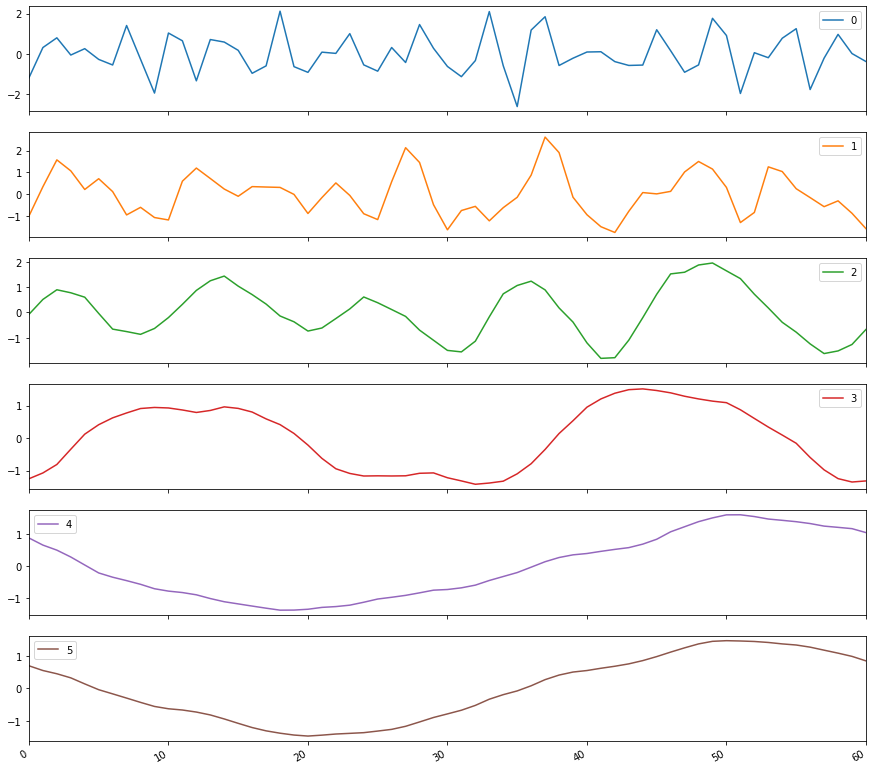

In [96]:
pd.DataFrame(waves[0].reshape(61, 6)).plot(subplots=True, figsize=(15,15))